<font size='5'><h1 ><center> **Plants Identification by Deep Learning**</center></h1></font>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#acces">Introduction</a></li>
        <li><a href="#acces">Acces files in drive</a></li>
        <li><a href="#Preprocess_data">Data preprocessing and exploring </a></li>
        <li><a href="#modeling">Modeling</a></li>
        <li><a href="#mevaluation">Evaluation</a></li>
        <li><a href="#prediction">Prediction</a></li>
    </ol>
</div>
<br>

### **Introduction**

<font size='3'>Automated species identification has been a promising challenge for taxonomy, biology, and ecology for 15 years. It involves assigning a scientific name to an individual plant by placing it into a taxon, as defined by taxonomy. Our project aims to create an automated plant identification solution using a CNN built from scratch in Keras with TensorFlow. We will train this model on a dataset of five flower types: daisy, dandelion, rose, sunflower, and tulip.<font>

# Memory Information

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.67GB
Available: 11.76GB
Used: 628.00MB
Percentage: 7.2%


# GPU Information

In [2]:
! nvidia-smi

Fri Aug  2 09:33:22 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### **Access files in Drive**
> We can access files in Drive in a number of ways, including: Mounting our Google Drive in the runtime's virtual machine using an authorization code




In [3]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


#### Load required libraries

In [4]:
import numpy as np # linear algebra
import pandas as pd  # data processing
import os #  to interact with files using there paths
from sklearn.datasets import load_files

### Loading the Data

In [5]:
#The path of our data on drive
data_dir =  r'/gdrive/My Drive/flowers'

#Loading our Data
data = load_files(data_dir)

### **Data Preprocessing and exploring**

In [6]:
folders=os.listdir("/gdrive/My Drive/flowers")
print(folders)

['sunflower', 'tulip', 'daisy', 'dandelion', 'rose']


#### We have one folder for each flower classe or type. We are going to load it into two numpy arrays as follows :    

- X - filenames (Training data)
- y - flower names(Target labels)

In [7]:
X = np.array(data['filenames'])
y = np.array(data['target'])
labels = np.array(data['target_names'])

# How the arrays look like?
print('Data files - ',X)
print('Target labels - ',y)

Data files -  ['/gdrive/My Drive/flowers/tulip/7144016605_e159b6c06b_m.jpg'
 '/gdrive/My Drive/flowers/tulip/7166623602_256179ab00_n.jpg'
 '/gdrive/My Drive/flowers/tulip/4300258119_b03f2f956e.jpg' ...
 '/gdrive/My Drive/flowers/tulip/5718510972_9a439aa30a_n.jpg'
 '/gdrive/My Drive/flowers/tulip/20896271018_9f1dc41c93_n.jpg'
 '/gdrive/My Drive/flowers/tulip/402525114_eaa60c8341_m.jpg']
Target labels -  [4 4 4 ... 4 4 4]


#### As you can see, numbers in the **Target labels - [4 4 2 ... 1 2 3]** are corresponding to class label. We need to change them to a vector of 5 elements ( 5 classes )

### Remove .pyc or .py files
> If you explore our data closely, you will see some other files that are not images with the '.pyc' and '.py' extensions, especially in the dandelion class. So, we have to remove them.

> Don't worry, you may not want to do it that way. however, you can simply work with files whose names end with the extension .jpg using the **endswith ('jpg')** function properly.

In [8]:
# Remove .pyc or .py files
pyc_file_pos = (np.where(file==X) for file in X if file.endswith(('.pyc','.py')))
for pos in pyc_file_pos:
    X = np.delete(X,pos)
    y = np.delete(y,pos)

print('Number of training files : ', X.shape[0])
print('Number of training targets : ', y.shape[0])

Number of training files :  1081
Number of training targets :  1081


### Load the images
> We only have the filenames in X. So, it's time to load the images from the filename with an appropriate size which ensures a small number of parameters to minimize runtime as much as possible during the training step and save them to X. Here we are going to use (150, 150) as the image size for the previous reasons.


In [9]:
from keras.preprocessing.image import img_to_array, load_img

def convert_img_to_arr(file_path_list):
    arr = []
    #size=64,64
    img_width, img_height = 150,150
    for file_path in file_path_list:
        img = load_img(file_path, target_size = (img_width, img_height))
        img = img_to_array(img)
        arr.append(img)
        #arr.append(cv2.resize(img,size))
    return arr

X = np.array(convert_img_to_arr(X))
print(X.shape)
print('First training item : ',X[0])

(1081, 150, 150, 3)
First training item :  [[[228. 228. 228.]
  [229. 229. 229.]
  [229. 229. 229.]
  ...
  [225. 225. 225.]
  [225. 225. 225.]
  [222. 222. 222.]]

 [[230. 230. 230.]
  [231. 231. 231.]
  [232. 232. 232.]
  ...
  [226. 226. 226.]
  [226. 226. 226.]
  [224. 224. 224.]]

 [[230. 230. 230.]
  [231. 231. 231.]
  [232. 232. 232.]
  ...
  [227. 227. 227.]
  [226. 226. 226.]
  [225. 225. 225.]]

 ...

 [[220. 210. 211.]
  [ 61.  58.  23.]
  [ 56.  58.  36.]
  ...
  [ 18.  16.  17.]
  [ 29.  24.   4.]
  [ 52.  42.  41.]]

 [[116. 124. 137.]
  [ 19.  33.   0.]
  [ 46.  64.  14.]
  ...
  [ 20.  18.  19.]
  [  1.   0.   0.]
  [ 44.  47.  30.]]

 [[ 26.  31.   9.]
  [ 27.  28.  32.]
  [ 12.  20.   7.]
  ...
  [ 27.  24.  15.]
  [ 29.  27.  15.]
  [ 15.  16.  11.]]]


#### **Few Take Aways**
#### Note that the shape of training data is **(4323, 150, 150, 3)**
#####  

-   **4323** is the **number** of training items or files,
-   **(150,150)** is the **target size** or image size provided while loading image
-   **3** refers to the **depth** for colored images ( RGB channels ).

### Take a look at some pictures

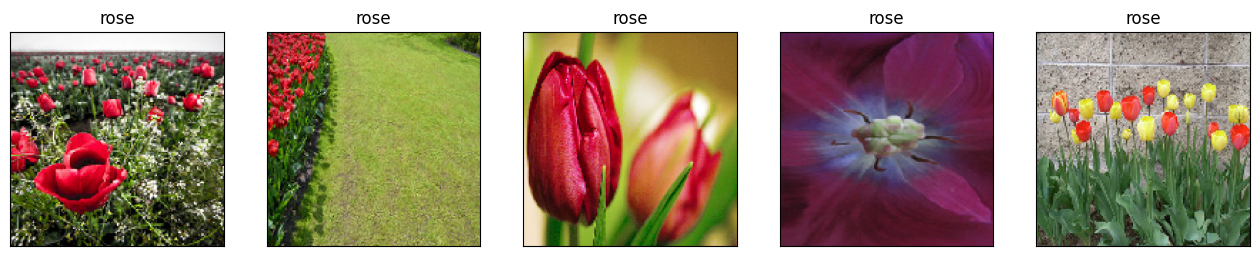

In [10]:
#Let's look at first 5 training data.

import matplotlib.pyplot as plt

fig = plt.figure(figsize = (16,9))
for i in range(5):
    ax = fig.add_subplot(1,5,i+1,xticks=[],yticks=[])
    ax.imshow((X[i].astype(np.uint8)))
    plt.title(folders[y[i]])

Spectacular! The flowers are so beautiful :)

### Why we need to [rescal](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) our data ?
> rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor. So all values in X will lie within 0 to 1 !



In [11]:
# Let's resize or rescale training data
X = X.astype('float32')/255

# Let's confirm the number of classes :)
no_of_classes = len(np.unique(y))
no_of_classes

2


> Great! we will predict the flowers of five classes



In [12]:
y

array([4, 4, 4, ..., 4, 4, 4])

 ### Let's converts a class vector (integers) to binary class matrix:
**Arguments:**
- **y**	class vector to be converted into a matrix (integers from 0 to no_of_classes).
- **no_of_classes** total number of classes.
- **dtype**	The data type expected by the input. Default: 'float32'.

**Returns:**
- A binary matrix representation of the input. The classes axis is placed last. [for more...](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/keras/utils/to_categorical)

In [33]:
!pip install tensorflow==2.0.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.0.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0)
ERROR: No matching distribution found for tensorflow==2.0.0


### Split the data into train, test and valid subsets
> Here we are going to split our dataset into **80% train**, **10% validation**, and **10% test**.


In [17]:
from sklearn.model_selection import train_test_split

# let's splite the data into subsets and explore their shapes !

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
print('The test Data Shape ', X_test.shape[0])

X_test, X_valid, y_test, y_valid = train_test_split(X_test,y_test, test_size = 0.5)
print('The training Data Shape ', X_valid.shape[0])

The test Data Shape  217
The training Data Shape  109


In [18]:
print('The train Data Shape ', X_train.shape[1:])

The train Data Shape  (150, 150, 3)


> (150, 150, 3) refers to the shape of the data (images) that will be fed into our CNN



### **CNN Implementation**
> This is an image that shows how our CNN architecture looks like :



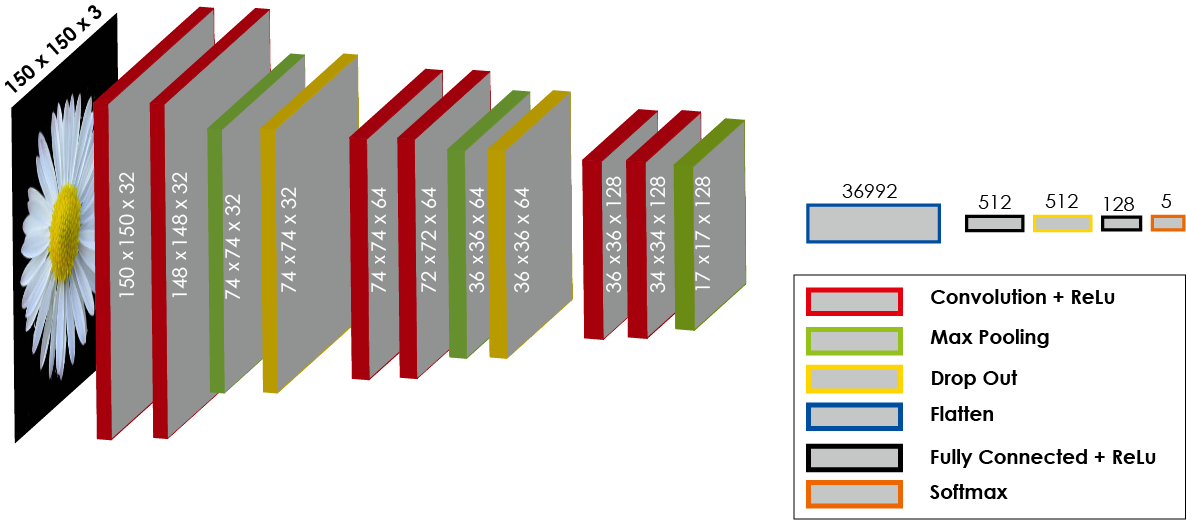

### Import the necessary libraries
> As you can see here, Keras library allows us to import the different functions for building our CNN architecture (Conv2D, MaxPooling2D, Dense, Flatten Dropout.




In [21]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

### CNN Architecture
I will be using Sequential method as I am creating a sequential model. **Sequential model means that all the layers of the model will be arranged in sequence**, then i will add:
> * 2 x convolution layer of 32 channel of 3x3 kernal and same padding;
* 1 x maxpool layer of 2x2 pool size;
* 1 x droupt with a frequency of rate equal to 0.25;
* 2 x convolution layer of 64 channel of 3x3 kernal and same padding:
* 1 x maxpool layer of 2x2 pool size
* 1 x droupt with a frequency of rate equal to 0.25;
* 2 x convolution layer of 128 channel of 3x3 kernal and same padding;
* 1 x maxpool layer of 2x2 pool size;
* 1 x flatten;
* 1 x dense layer of 512
* 1 x dropout set at 0.5
* 1 x dense layer of 128
* 1 x Dense Softmax layer of 5 units

=> **Dropout** is a technique of regularisation which helps us to prevent _**overfitting**_.

If you noticed, I also add **ReLu** (Rectified Linear Unit) activation to each layers so that all the negative values are not passed to the next layer:)


In [22]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', input_shape=X_train.shape[1:], activation='relu', name='Conv2D_1'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_1'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_3'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_4'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_2'))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='Conv2D_5'))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_6'))
model.add(MaxPool2D(pool_size=(2,2), name='Maxpool_3'))

model.add(Flatten())
model.add(Dense(units=512, activation='relu', name='Dense_1'))
model.add(Dropout(0.5))
model.add(Dense(units=128, activation='relu', name='Dense_2'))
model.add(Dense(units=no_of_classes, activation='softmax', name='Output'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model Summary

In [23]:
# Getting the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 148, 148, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Maxpool_1 (MaxPooling2D)             │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 74, 74, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4 (Conv2D)                    │ (None, 72, 72, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Maxpool_2 (MaxPooling2D)             │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_5 (Conv2D)                    │ (None, 36, 36, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_6 (Conv2D)                    │ (None, 34, 34, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Maxpool_3 (MaxPooling2D)             │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,293,346 (73.60 MB)

 Trainable params: 19,293,346 (73.60 MB)

 Non-trainable params: 0 (0.00 B)

### Compiling the model
> I will be using the **RMSprop** optimizer to Maintain a moving (updated) average of the square of the gradients during training, here, in this case, it is fixed at 0.001. If our training bounces a lot off epochs, we need to reduce the learning rate to maintain a moving average.




In [25]:
from keras.optimizers import RMSprop

# Use 'learning_rate' instead of 'lr'
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### Fitting the model
For callbacks, I employed:


>* **ModelCheckpoint :** Callback to save the model or model weights at certain frequencies (in this case, the model will be saved That only if the validation accuracy of the model at the present time is greater than that at the last time)
* **ReduceLRonPlateau :** Reduce learning rate when a performance metric has stopped improving (in this case, I have set the patience at 3, which means that the model will reduce the learning rate if it does not see any increase in the validation precision in 3 epochs)

   I am using **model.fit_generator** because I am using **ImageDataGenerator** to pass data to the model. I will pass the train and valid data to **fit_generator**. In **fit_generator**, **steps_per_epoch** will set the **batch_size** to pass training data to the model and **validation_steps** will do the same for validation data. These settings could be changed according to each system specifications.



In [49]:
import numpy as np
from tensorflow.keras.utils import to_categorical
import time
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Time to train our model !
epochs = 100
batch_size = 32
y_train_encoded = to_categorical(y_train)
y_valid_encoded = to_categorical(y_valid)

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# No data augmentation for the validation set
test_datagen = ImageDataGenerator()

# Update the generators to use the encoded targets
train_generator = train_datagen.flow(
    X_train, y_train_encoded,  # Use encoded target
    batch_size=batch_size
)

validation_generator = test_datagen.flow(
    X_valid, y_valid_encoded,  # Use encoded target
    batch_size=batch_size
)

# *** Move the Dense layer addition before compiling the model ***
model.add(Dense(5, activation='softmax'))

# Use 'learning_rate' instead of 'lr'
optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model after adding all layers

# ... (rest of your code remains the same)

checkpointer = ModelCheckpoint(filepath='/gdrive/My Drive/PId_Best.keras', save_best_only=True, verbose=1)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

start = time.time()

# let's get started !
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    verbose=1,
                    steps_per_epoch=len(X_train) // batch_size,
                    callbacks=[checkpointer, learning_rate_reduction])


end = time.time()

duration = end - start
print('\n This Model took {:.2f} seconds ({:.1f} minutes) to train for {} epochs'.format(duration, duration/60, epochs))

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7036 - loss: 1.5280
Epoch 1: val_loss improved from inf to 1.44813, saving model to /gdrive/My Drive/PId_Best.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 350ms/step - accuracy: 0.7089 - loss: 1.5270 - val_accuracy: 0.8899 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 2/100

Epoch 2: val_loss did not improve from 1.44813
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.8899 - val_loss: 1.4481 - learning_rate: 0.0010
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9084 - loss: 1.4236
Epoch 3: val_loss improved from 1.44813 to 1.36061, saving model to /gdrive/My Drive/PId_Best.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.9087 - loss: 1.4228 - val_accuracy: 0.8899 - val_loss: 1.3606 - learning_rate: 0.0010
Epoch 4/100

Epoch 4: val_loss did not improve from 1.36061

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/

### Model Evaluation

In [54]:
import numpy as np
from tensorflow.keras.utils import to_categorical

# ... (rest of your code)

# One-hot encode the test labels
y_test_encoded = to_categorical(y_test)

(eval_loss, eval_accuracy) = model.evaluate(
    X_test, y_test_encoded,  # Use encoded test labels
    batch_size=batch_size, verbose=2)

print("Accuracy: {:.2f}%".format(eval_accuracy * 100))
print("Loss: {}".format(eval_loss))

4/4 - 3s - 857ms/step - accuracy: 0.8889 - loss: 1.1963
Accuracy: 88.89%
Loss: 1.1962960958480835


### Acuuracy and Loss graphs

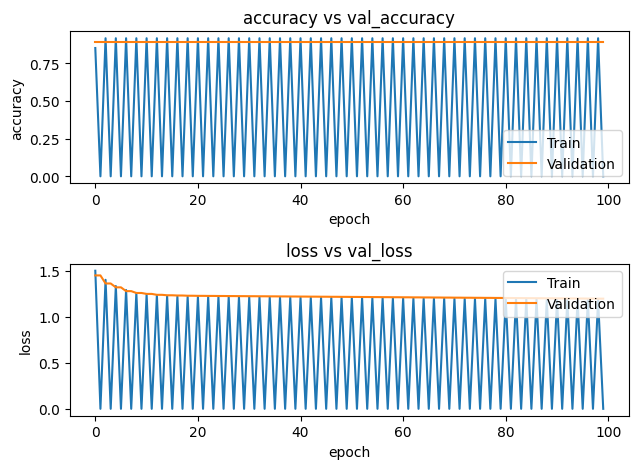

In [55]:
# Let's visualize the train/validation loss and accuracy wrt epochs

import matplotlib.pyplot as plt
def plot(history):
    plt.figure(1)
    #plt.figure(figsize=(10,10))

     # summarize history for accuracy

    plt.subplot(211)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy vs val_accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

     # summarize history for loss

    plt.subplot(212)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss vs val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

# Finaly, let's call the plot function with the 'result' parameter

plot(history)

#### **Few take aways**
> * From the Training and Validation Accuracy graph above, our model does not seem to be overfitted, which is great!
* Also, Our Training and Validation Loss graph above also indicates a good learning rate.



### Prediction
> Finally, let us test our model against more random samples from the test data !



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


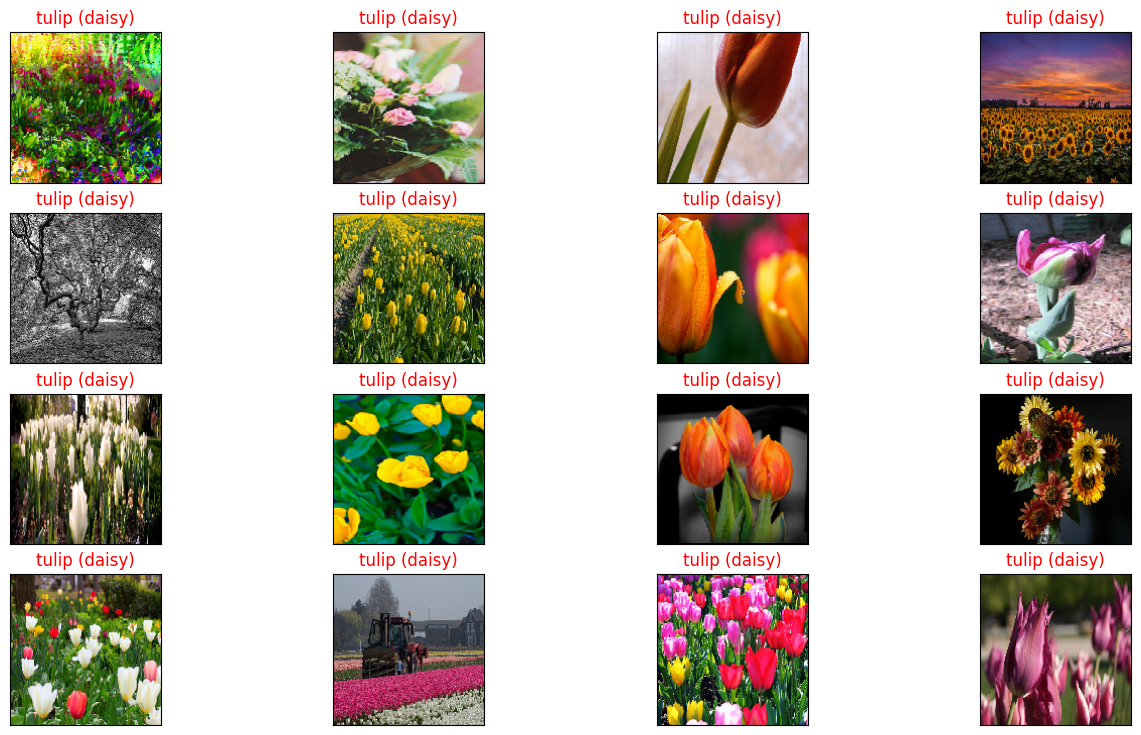

In [56]:
# Let's visualize some random test prediction.
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = np.argmax(y_test[idx])
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

visualize_pred(model.predict(X_test))

### Confusion matrix
I will plotting confusion matrix according to test datas. **0,1,2,3,4** values in this matrix means **daisies, dandelions, roses, sunflowers, tulips** respectively

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


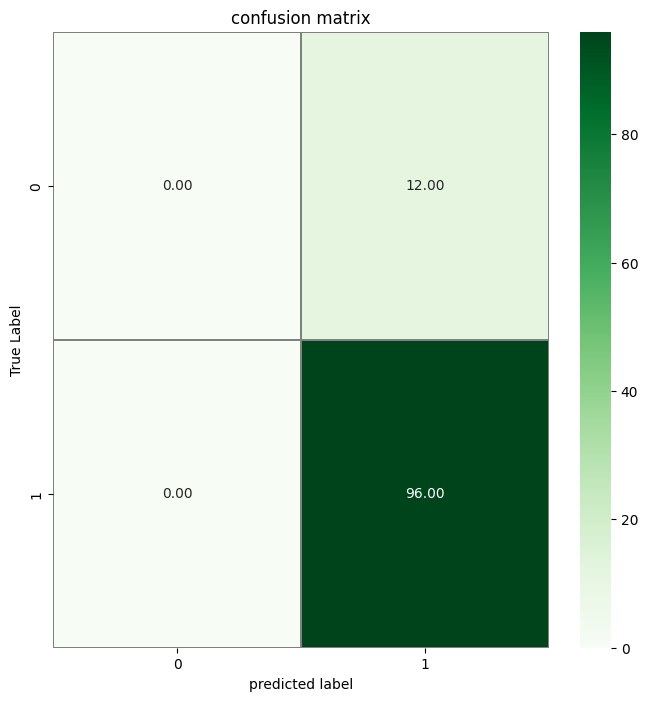

In [58]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Assuming y_test is already in the correct format (e.g., a list of class indices)
Y_true = y_test
confusion_mtx = confusion_matrix(Y_true,Y_pred_classes)
f,ax = plt.subplots(figsize = (8,8))
sns.heatmap(confusion_mtx,annot=True,linewidths = 0.01,cmap="Greens",
            linecolor = "gray",fmt = ".2f",ax=ax
            )
plt.xlabel("predicted label")
plt.ylabel("True Label")
plt.title("confusion matrix")
plt.show()

### **Few Take aways:**
- The most difficult to detect the type of flower is **tulip**.
- The easiest to detect the type of flower is **daisy**.
- Our confusion matrix indicates that a lot of prediction errors came from distinguishing between **rose** and **tulip**.

### Loading the model
> Here we're gonna load our best model trained befor, then make some predictions with it !

In [72]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load a pre-trained ResNet50 model (excluding top layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))


# Add your own classification layers
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))  # Adjust '10' based on number of classes

# Compile and train (similar to the previous example)


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


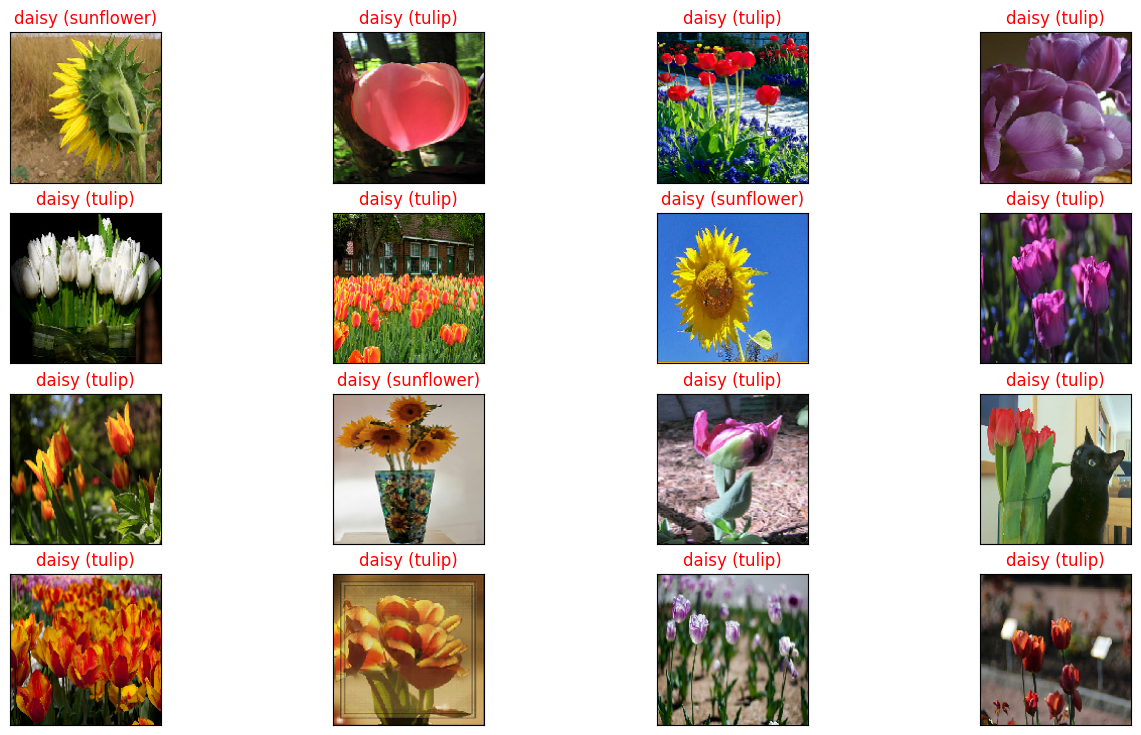

In [73]:
def visualize_pred(y_pred):
# plot a random sample of test images, their predicted labels, and ground truth
    fig = plt.figure(figsize=(16, 9))
    for i, idx in enumerate(np.random.choice(X_test.shape[0], size=16, replace=False)):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(X_test[idx]))
        pred_idx = np.argmax(y_pred[idx])
        true_idx = y_test[idx] # y_test is already a 1D array of class indices
        ax.set_title("{} ({})".format(labels[pred_idx], labels[true_idx]),
                     color=("green" if pred_idx == true_idx else "red"))

# Use the full model for prediction, not just the base model
visualize_pred(model.predict(X_test))

## **Conclusion**
The classification precision achieved is great! Considering the quality of data which have been impacted by some issues including :
- Images with noisy backgrounds;
- Multiple plant species appearing in the same image;
- The plant transforms morphologically during its growth... etc.

>This project can be considered quite successful. Of course, there is still much room for improvement. firstly, we can apply the [**Transfer Learning**](https://keras.io/guides/transfer_learning/) principe with advanced and popular architectures as VGG16 or ResNet-50 and train it from fine-tuned from pre-trained weights on the popular **ImageNet** dataset.


**Author : ZEKAOUI Nour Eddine**

*   My [LinkedIn](https://www.linkedin.com/in/nour-eddine-zekaoui-ba43b1177/)
*   My [GitHub](https://github.com/zekaouinoureddine)



## **Thank you a lot for your interest** ☻